In [1]:
from pathlib import Path
import glob, sys, os
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from p_tqdm import p_map
import seaborn as sns
sns.set_context('poster')
import matplotlib as mpl

In [2]:
def ce_func(consumption, dims, eta=2):
    """Calculate CRRA function"""
    return ((consumption ** (1 - eta) / (1 - eta)).mean(dims) * (1 - eta)) ** (
        1 / (1 - eta)
    )

In [3]:
# text specs
text_specs = dict(
    fontsize=15,
    xycoords='axes fraction'
)

# palette = ["#0077a0", "#fd1115"]
palette = ['mediumslateblue', 'mediumseagreen', 'coral']

In [4]:
year = 2095
ssp = 'SSP3'
model = 'IIASA GDP'
rcp = 'ssp370'
gas = 'CO2_Fossil'

selection = dict(year=year, model=model, ssp=ssp)
global_cons_no_cc = f'/mnt/CIL_integration/explainer_plot_data/AMEL/2020/risk_aversion_constant_eta2_rho0_global_consumption.nc4'
global_cons_cc = f'/mnt/CIL_integration/explainer_plot_data/AMEL/2020/global_consumption_no_pulse.nc4'
fair = f'/mnt/CIL_integration/explainer_plot_data/AMEL/2020/fair_control.nc4'

global_cons_no_cc = (xr.open_dataset(global_cons_no_cc).sel(selection).to_array().rename('global_cons_no_cc')/1e12).values.item()
global_cons_cc = xr.open_dataset(global_cons_cc).sel(**selection,  rcp=rcp).to_array().rename('global_cons_cc')/1e12
fair = xr.open_dataset(fair).sel(rcp=rcp, gas=gas, year=year)

raw = global_cons_cc.to_dataframe().reset_index()

mean = global_cons_cc.mean('simulation').values.item()
ce = ce_func(global_cons_cc,  ['simulation']).values.item()

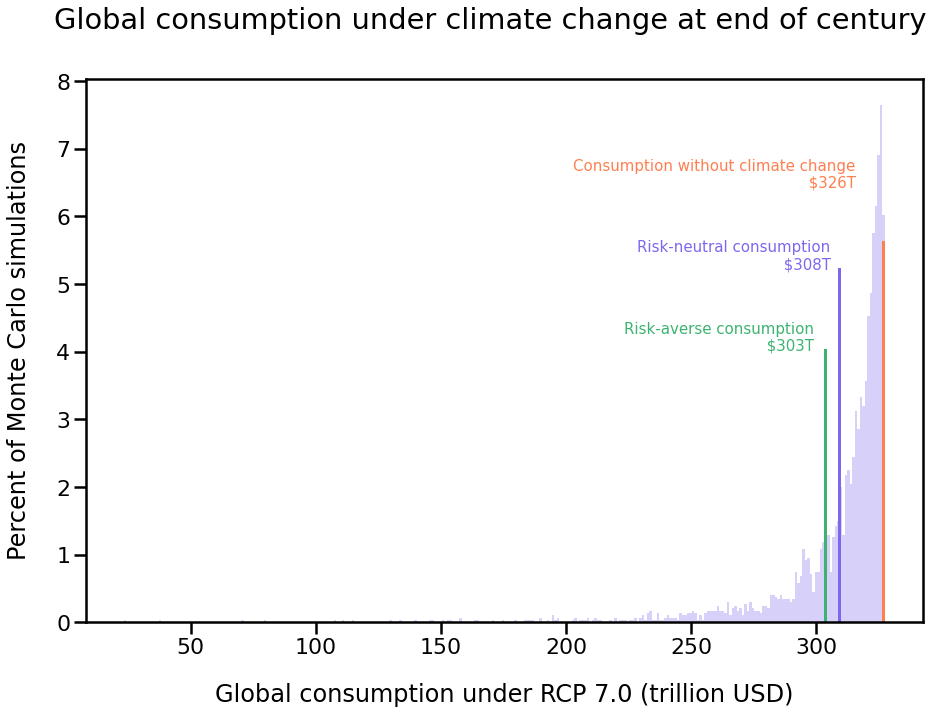

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))

sns.histplot(raw,
             x='global_cons_cc',
             stat='percent',
             color=palette[0],
             edgecolor=None,
             alpha=0.3,
             binwidth=1,
             ax=ax
            )

plt.axvline(mean, 0, 0.65, color=palette[0])
plt.axvline(ce, 0, 0.5, color=palette[1])
plt.axvline(global_cons_no_cc, 0, 0.7, color=palette[2])


plt.annotate(f'Risk-neutral consumption\n ${"{:,}".format(int(mean))}T', (0.89, 0.65),
             horizontalalignment='right',
             color=palette[0],
             **text_specs
            )

plt.annotate(f'Risk-averse consumption\n ${"{:,}".format(int(ce))}T', (0.87, 0.5),
             horizontalalignment='right',
             color=palette[1],
             **text_specs
            )

plt.annotate(f'Consumption without climate change\n ${"{:,}".format(int(global_cons_no_cc))}T', (0.92, 0.8),
             horizontalalignment='right',
             color=palette[2],
             **text_specs
            )

ax.set_ylabel('Percent of Monte Carlo simulations', labelpad=25)
ax.set_xlabel('Global consumption under RCP 7.0 (trillion USD)', labelpad=25)

fig.suptitle('Global consumption under climate change at end of century')

plt.savefig('/mnt/CIL_integration/explainer_plots/fig_3a.pdf', bbox_inches='tight')
plt.savefig('/mnt/CIL_integration/explainer_plots/fig_3a.png', bbox_inches='tight', dpi=300)

In [6]:
damages = '/mnt/CIL_integration/explainer_plot_data/AMEL/2020/fair_control_damages.nc4'
damages = xr.open_dataset(damages).to_array().rename('damages').sel(**selection, rcp=rcp)/1e12

raw_damages = damages.to_dataframe().reset_index()

mean_damages = damages.mean('simulation').values.item()
ce_damages = global_cons_no_cc - ce_func(global_cons_no_cc - damages,  ['simulation']).values.item()

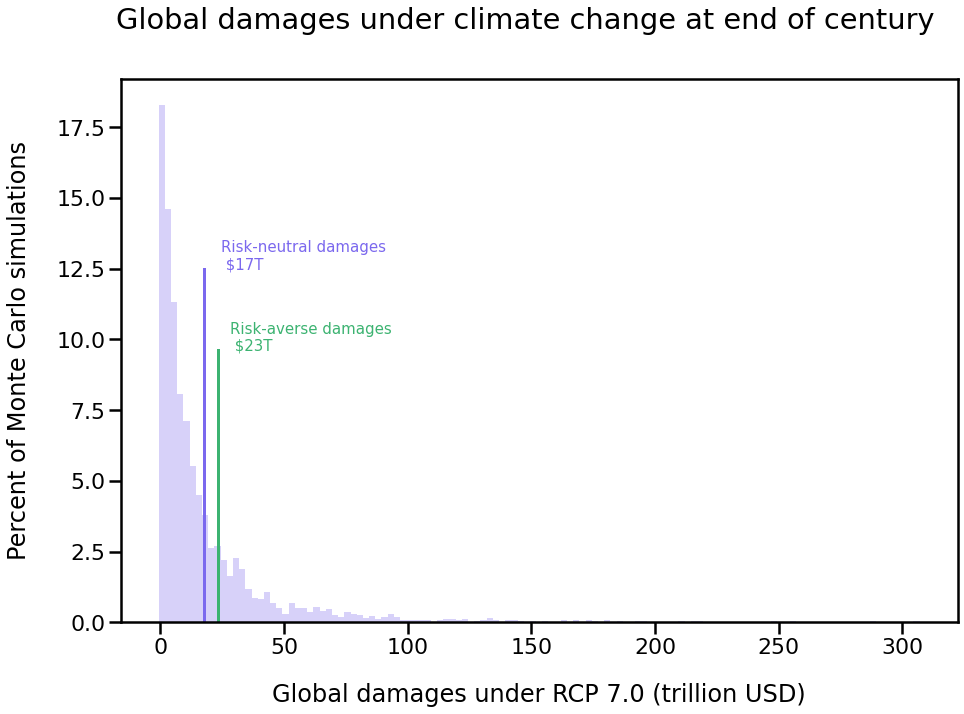

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))

sns.histplot(raw_damages,
             x='damages',
             stat='percent',
             color=palette[0],
             edgecolor=None,
             alpha=0.3,
             ax=ax
            )

plt.axvline(mean_damages, 0, 0.65, color=palette[0])
plt.axvline(ce_damages, 0, 0.5, color=palette[1])

plt.annotate(f'Risk-neutral damages\n ${"{:,}".format(int(mean_damages))}T', (0.12, 0.65),
             color=palette[0],
             **text_specs
            )

plt.annotate(f'Risk-averse damages\n ${"{:,}".format(int(ce_damages))}T', (0.13, 0.5),
             color=palette[1],
             **text_specs
            )

ax.set_ylabel('Percent of Monte Carlo simulations', labelpad=25)
ax.set_xlabel('Global damages under RCP 7.0 (trillion USD)', labelpad=25)

fig.suptitle('Global damages under climate change at end of century')

plt.savefig('/mnt/CIL_integration/explainer_plots/fig_3b.pdf', bbox_inches='tight')
plt.savefig('/mnt/CIL_integration/explainer_plots/fig_3b.png', bbox_inches='tight', dpi=300)